In [ ]:
import numpy as np
from scipy.io import loadmat
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt

# 1. 正则化的线性回归
## 1.1 数据读取及可视化

In [2]:
# 读入数据
def loadData(path):
    data = loadmat(path)
    X, y, Xval, yval, Xtest, ytest = data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']
    return X, y, Xval, yval, Xtest, ytest


In [3]:
path = r'ex12data.mat'
X, y, Xval, yval, Xtest, ytest = loadData(path)
print(X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

(12, 1) (12, 1) (21, 1) (21, 1) (21, 1) (21, 1)


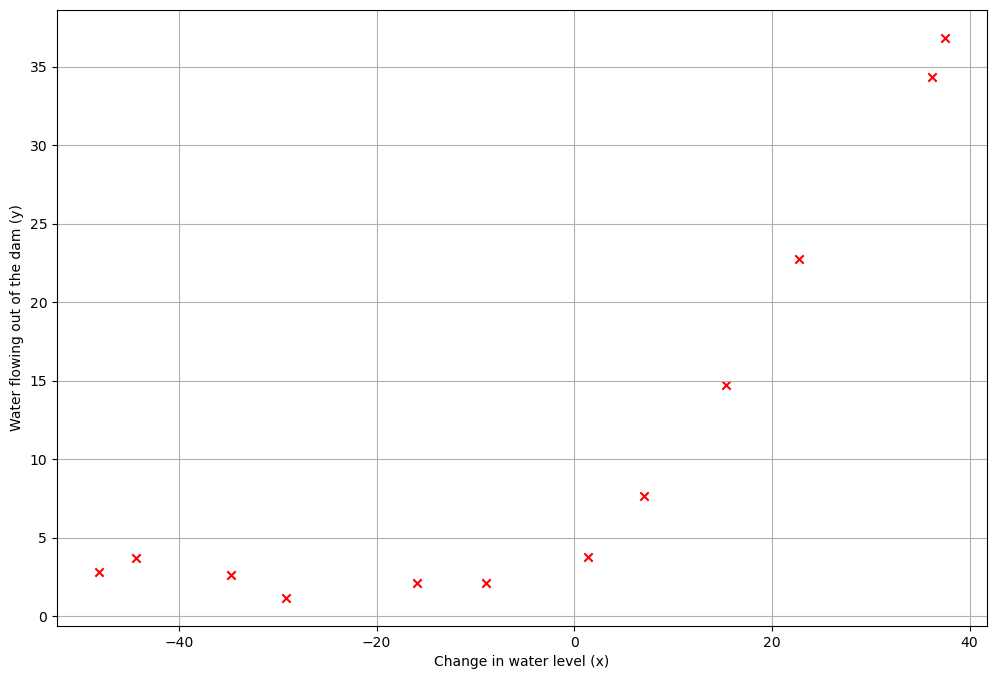

In [4]:
# 可视化
def plotData(X,y):
    plt.figure(figsize=(12,8))
    plt.scatter(X, y,c='r', marker='x')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.grid(True)
plotData(X,y)

## 1.2 正则化线性回归的代价函数

In [5]:
# 插入x0 = 1
X, Xval, Xtest = [np.insert(x, 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
print(X.shape, Xval.shape, Xtest.shape)
# ((12, 2), (21, 2), (21, 2))
 
# 代价函数
def linearRegCostFunc(theta, X, y, l=1):
    m = X.shape[0] # 12
    theta = theta[:, np.newaxis] 
    front=X@theta-y

    cost=1/(2*m)*((front.T@front)+l*np.sum(theta[1:]**2))
    return cost[0][0]
theta=np.ones(X.shape[1])
linearRegCostFunc(theta, X, y)

(12, 2) (21, 2) (21, 2)


303.9931922202643

## 1.3 代价函数的梯度

In [6]:
# 正则化梯度下降
def linearRegCostFuncGradient(theta, X,y, l=1):
    m = X.shape[0] # 12
    theta = theta[:, np.newaxis] 
    front=X@theta-y
    grad=1/m*X.T@front
    grad[1:]=grad[1:]+(l/m)*theta[1:]
    return grad # (2,1)


linearRegCostFuncGradient(theta,X,y)

array([[-15.30301567],
       [598.25074417]])

## 1.4 训练正则化线性回归（Fitting linear regression）与欠拟合（underfitting）

In [7]:
def trainLinearRegression(X,y,lmd):
    theta=np.zeros(X.shape[1])
    rslt = opt.minimize(fun=linearRegCostFunc,x0=theta,args=(X,y,lmd),
                     method='TNC',jac=linearRegCostFuncGradient)
    return rslt.x

fit_theta=trainLinearRegression(X,y,0)
fit_theta


array([13.08790351,  0.36777923])

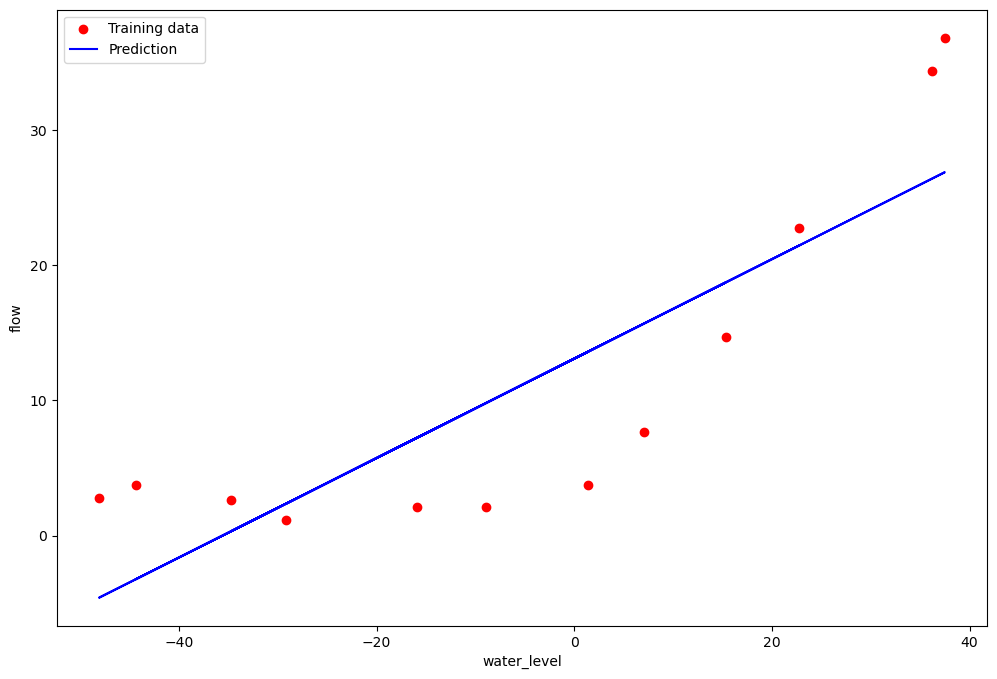

In [8]:
def plotData1(theta, X, y):
    fig,ax = plt.subplots(figsize=(12,8))
    plt.scatter(X[:,1], y, c='r', label="Training data")
    plt.plot(X[:,1], X @ theta, c = 'b', label="Prediction")
    ax.set_xlabel("water_level")
    ax.set_ylabel("flow")
    ax.legend()
    plt.show()

plotData1(fit_theta, X, y)

# 2. 偏差-方差理论
## 2.1 学习曲线

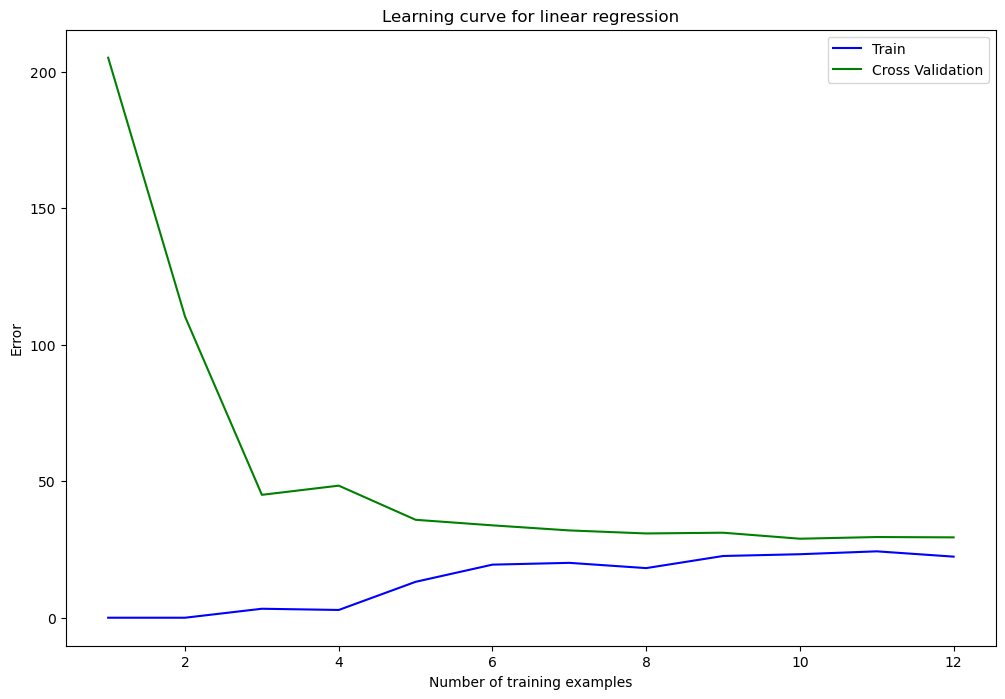

In [9]:

def plotLearningCurve(X, y, Xval, yval, l):
    """画出学习曲线"""
    size = range(1, len(X)+1)
    error_train, error_val = [], []
    for i in size:
        i_theta = trainLinearRegression(X[:i, :], y[:i], l)
        i_train_cost = linearRegCostFunc(i_theta, X[:i, :], y[:i], 0)
        i_val_cost = linearRegCostFunc(i_theta, Xval, yval)
        error_train.append(i_train_cost)
        error_val.append(i_val_cost)

    
    fix, ax = plt.subplots(figsize=(12, 8))
    ax.plot(size,error_train,label="Train",color="blue")
    ax.plot(size,error_val,label="Cross Validation",color="green")
    ax.legend()
    ax.set_xlabel("Number of training examples")
    ax.set_ylabel("Error")
    ax.set_title("Learning curve for linear regression")
    ax.grid(False)
    plt.show()

plotLearningCurve(X, y, Xval, yval, 0)

# 3. 可以拟合非线性数据的多项式回归（polynomialregression）

In [10]:
def polyFeatures(X, degree):

    Xpoly = X.copy()
   
    X=X[:,1]
 
    X=X[:,np.newaxis]
    for i in range(2,degree+1):
        Xpoly=np.hstack((Xpoly,X**i))
    return Xpoly


## 3.1 学习多项式回归

In [11]:
def get_means_std(X):
    """获得训练集的均值和误差"""
    means = np.mean(X,axis = 0) # 按列
    stds = np.std(X, axis=0, ddof=1)
    
    return means, stds
 

def featureNormalize(X, means, stds):
    X_norm=X.copy()
    X_norm[:,1:]=(X[:,1:]-means[1:])/stds[1:]
    return X_norm


In [12]:
# 数据处理
degree = 8
train_means, train_stds = get_means_std(polyFeatures(X, degree))
X_norm = featureNormalize(polyFeatures(X, degree), train_means, train_stds)
Xval_norm = featureNormalize(polyFeatures(Xval, degree), train_means, train_stds)
Xtest_norm = featureNormalize(polyFeatures(Xtest, degree), train_means, train_stds)

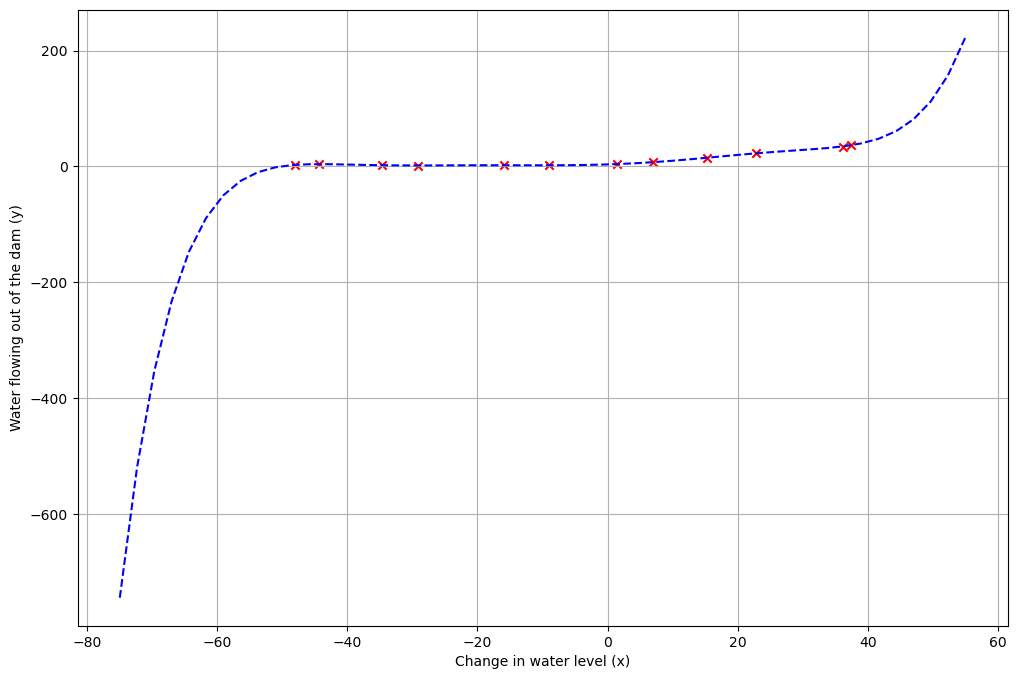

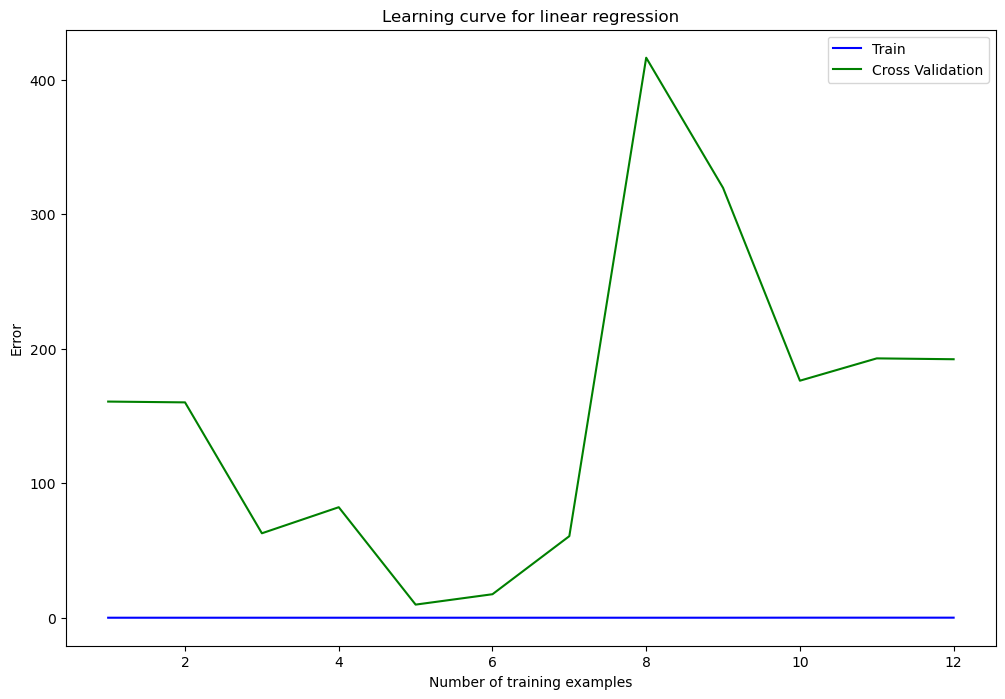

In [13]:
def plot_fit(means, stds, l):
    """画出拟合曲线"""
    theta = trainLinearRegression(X_norm,y, l)
    x = np.linspace(-75,55,50)
    xmat = x.reshape(-1, 1) # (50,)->(50,1)
    xmat = np.insert(xmat,0,1,axis=1) # 添加x0 = 1 
    Xmat = polyFeatures(xmat, degree) # 增加特征
    Xmat_norm = featureNormalize(Xmat, means, stds) # 特征规范化
    plotData(X[:,1], y) # 画出原始数据
    plt.plot(x, Xmat_norm @ theta, 'b--')# 画出拟合曲线

plot_fit(train_means, train_stds, 0)
plotLearningCurve(X_norm, y, Xval_norm, yval, 0) # 画出学习曲线

## 3.2 调整正则化参数

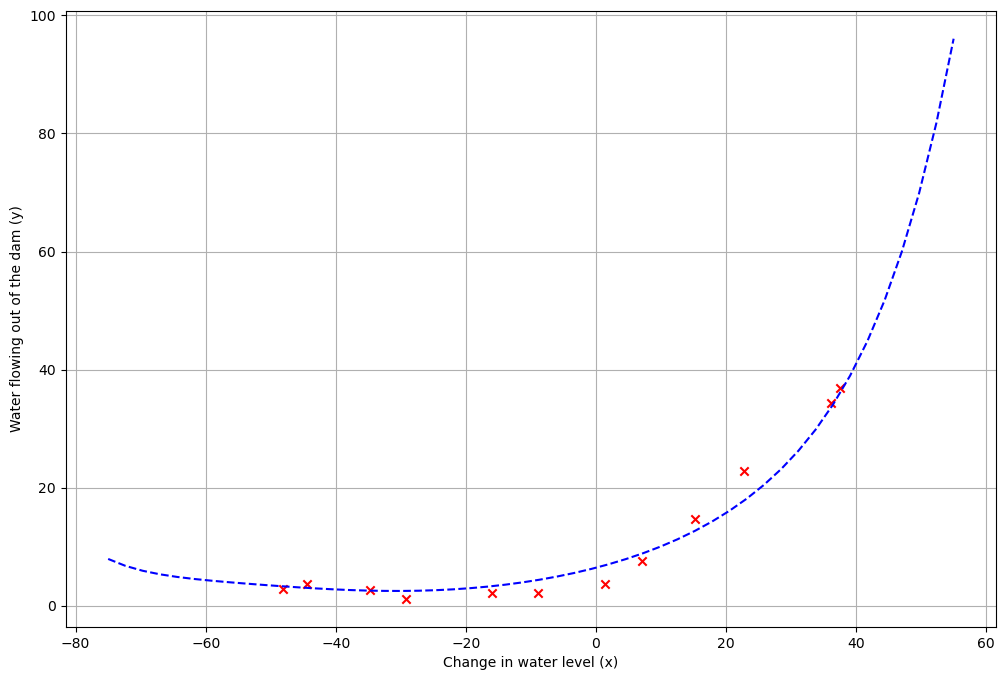

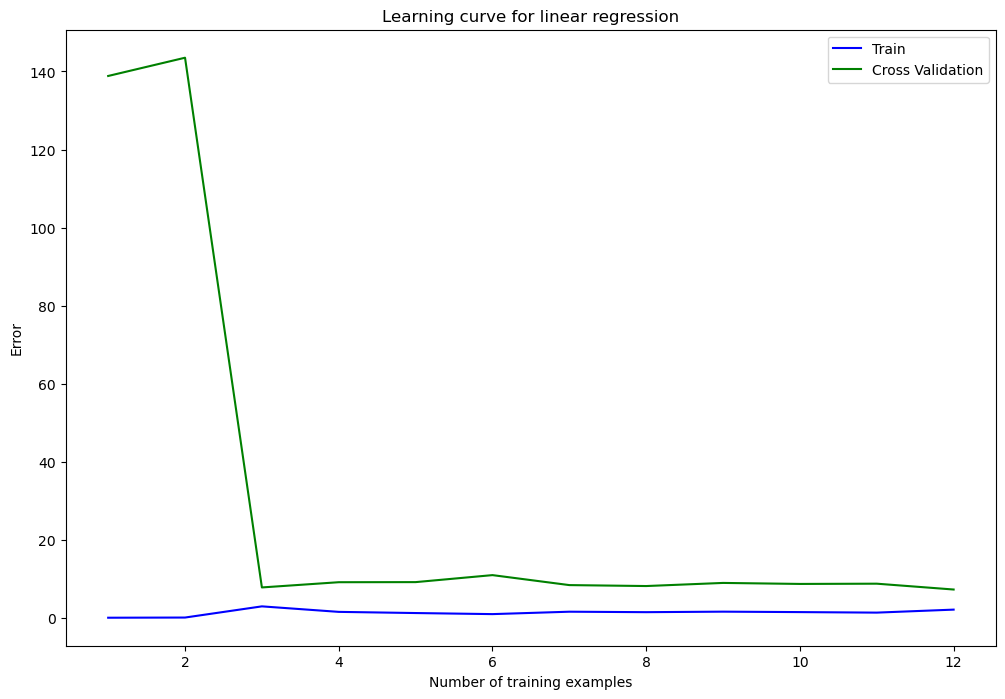

In [14]:
plot_fit(train_means, train_stds, 1)
plotLearningCurve(X_norm, y, Xval_norm, yval, 1) 

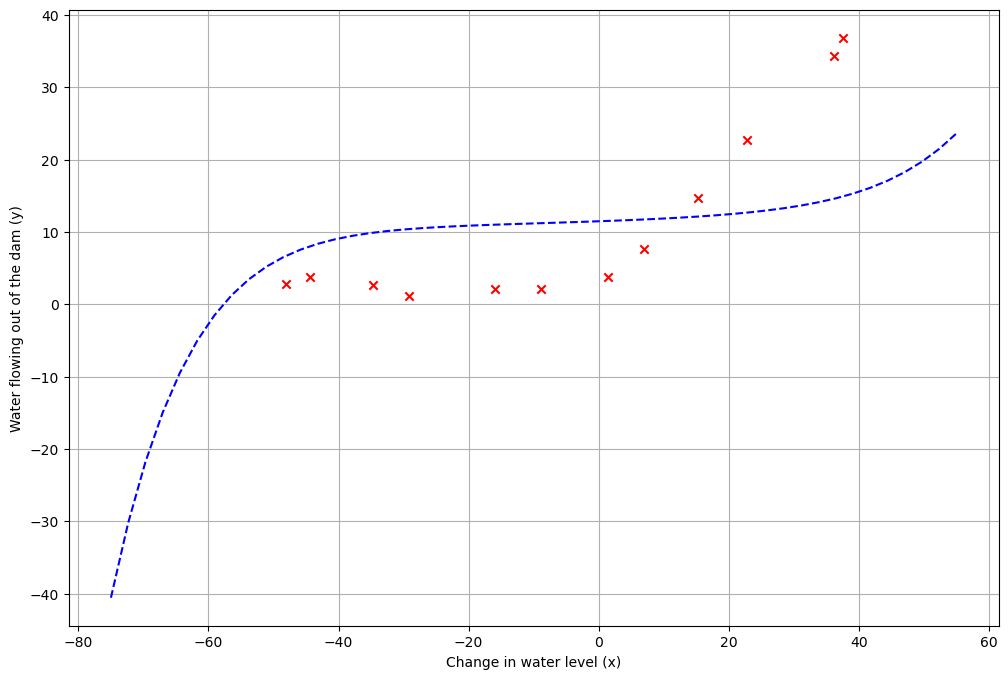

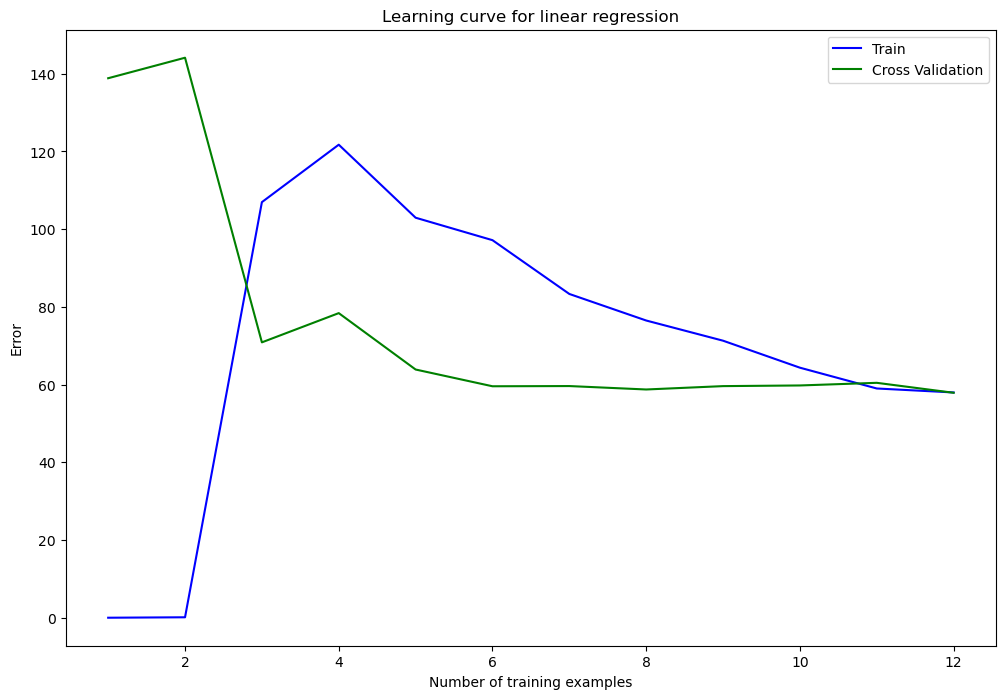

In [15]:
plot_fit(train_means, train_stds, 100)
plotLearningCurve(X_norm, y, Xval_norm, yval, 100) 

 ## 3.3 使用交叉验证数据集确定正则化参数lambda

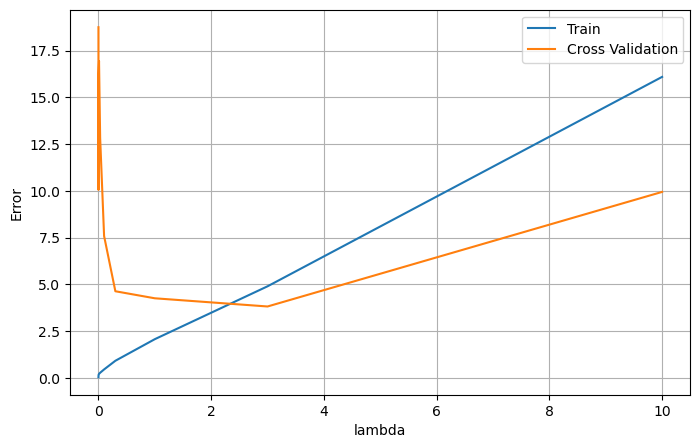

In [16]:
lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
errors_train, errors_val = [], []
for l in lambdas:
    theta = trainLinearRegression(X_norm, y, l)
    errors_train.append(linearRegCostFunc(theta,X_norm,y,0))  # 记得把lambda = 0
    errors_val.append(linearRegCostFunc(theta,Xval_norm,yval,0))
    
plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)

## 3.4 计算测试集误差

In [17]:
theta = trainLinearRegression(X_norm, y, 3)
print('test cost(l={}) = {}'.format(3, linearRegCostFunc(theta, Xtest_norm, ytest, 0)))

test cost(l=3) = 3.8599055627734438
